In [1]:
import geopandas as gpd
import urllib.request
import re
from bs4 import BeautifulSoup
import rasterio as ro
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.enums import Resampling
import random
import os
from os import path

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

Collect NDVI data

In [2]:
total_date_list = []
start_date = "20090101"
for i in range(2009,2019):
    start_date = str(i) + "0101"
    date_list = pd.date_range(start=start_date,freq='32D',periods=12).strftime("%Y_%m_%d").tolist()
    for j in range(12):
        total_date_list.append(date_list[j])



In [3]:
total_date_list

['2009_01_01',
 '2009_02_02',
 '2009_03_06',
 '2009_04_07',
 '2009_05_09',
 '2009_06_10',
 '2009_07_12',
 '2009_08_13',
 '2009_09_14',
 '2009_10_16',
 '2009_11_17',
 '2009_12_19',
 '2010_01_01',
 '2010_02_02',
 '2010_03_06',
 '2010_04_07',
 '2010_05_09',
 '2010_06_10',
 '2010_07_12',
 '2010_08_13',
 '2010_09_14',
 '2010_10_16',
 '2010_11_17',
 '2010_12_19',
 '2011_01_01',
 '2011_02_02',
 '2011_03_06',
 '2011_04_07',
 '2011_05_09',
 '2011_06_10',
 '2011_07_12',
 '2011_08_13',
 '2011_09_14',
 '2011_10_16',
 '2011_11_17',
 '2011_12_19',
 '2012_01_01',
 '2012_02_02',
 '2012_03_05',
 '2012_04_06',
 '2012_05_08',
 '2012_06_09',
 '2012_07_11',
 '2012_08_12',
 '2012_09_13',
 '2012_10_15',
 '2012_11_16',
 '2012_12_18',
 '2013_01_01',
 '2013_02_02',
 '2013_03_06',
 '2013_04_07',
 '2013_05_09',
 '2013_06_10',
 '2013_07_12',
 '2013_08_13',
 '2013_09_14',
 '2013_10_16',
 '2013_11_17',
 '2013_12_19',
 '2014_01_01',
 '2014_02_02',
 '2014_03_06',
 '2014_04_07',
 '2014_05_09',
 '2014_06_10',
 '2014_07_

In [4]:
sample_data = ro.open("https://github.com/AdamWilsonLab/emma_envdata/releases/download/raw_ndvi_modis/" + total_date_list[0]+".tif")
sample_data = sample_data.read()
sample_shape = np.shape(sample_data)
ndvi_dataset = np.empty((len(total_date_list),sample_shape[1],sample_shape[2]),dtype=np.float16)
for i in range(len(total_date_list)):
    band_j = ro.open("https://github.com/AdamWilsonLab/emma_envdata/releases/download/raw_ndvi_modis/" + total_date_list[i]+".tif")
    band_j = band_j.read()
    ndvi_dataset[i] = band_j


In [5]:
ndvi_dataset.shape

(120, 1634, 2035)

In [6]:
np.isnan(ndvi_dataset).any()

True

In [7]:
np.isinf(ndvi_dataset).any()

False

In [8]:
np.nanmin(ndvi_dataset)

80.0

In [9]:
np.nanmax(ndvi_dataset)

200.0

In [10]:
np.unique(ndvi_dataset)

array([80., 81., 82., ..., nan, nan, nan], dtype=float16)

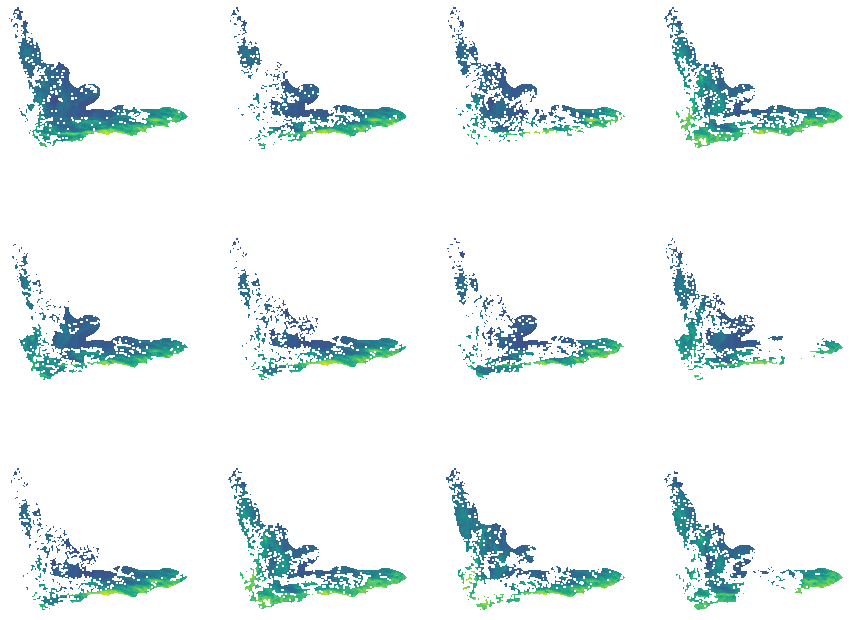

In [11]:
import random
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(ndvi_dataset[random_time,:,:])
    plt.axis('off')

In [12]:
ndvi_arr = (ndvi_dataset-100)/100

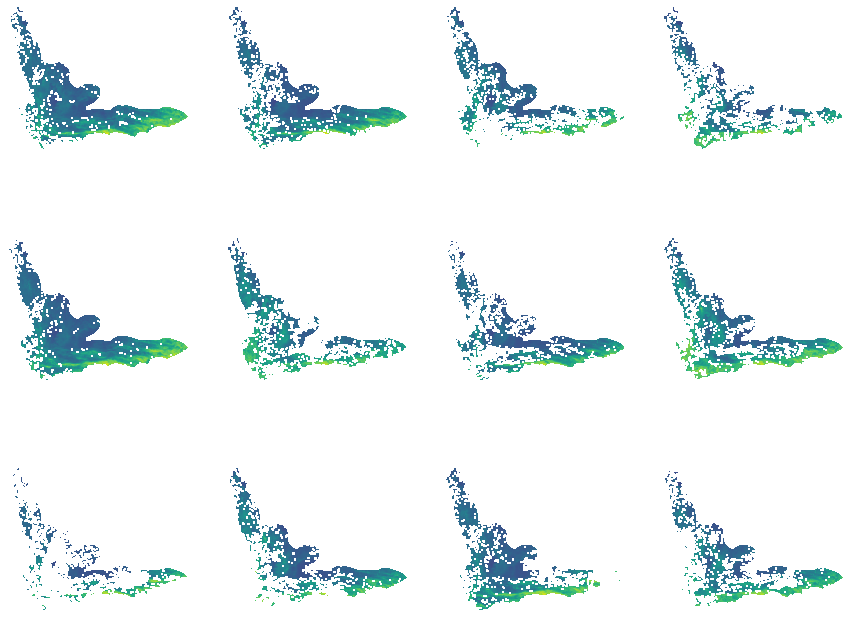

In [13]:
import random
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(ndvi_arr[random_time,:,:])
    plt.axis('off')

In [14]:
np.unique(ndvi_dataset)

array([80., 81., 82., ..., nan, nan, nan], dtype=float16)

collect static data

In [15]:
dem = ro.open("https://github.com/AdamWilsonLab/emma_envdata/releases/download/processed_static/nasadem.tif")
dem = dem.read()

In [16]:
dem.shape

(1, 1634, 2035)

In [17]:
np.nanmin(dem)

-2.88885

In [18]:
np.nanmax(dem)

2177.2297

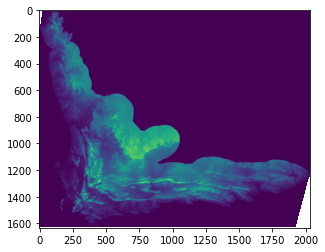

In [19]:
plt.imshow(dem[0])

In [20]:
soilN = ro.open("https://github.com/AdamWilsonLab/emma_envdata/releases/download/processed_static/soil_Total_N_.tif")
soilN = soilN.read()

In [21]:
np.nanmin(soilN)

-3.4e+38

In [22]:
for i in range(1634):
    for j in range(2035):
        if soilN[0,i,j] <0 :
            soilN[0,i,j] = np.nan
        else:
            pass

In [23]:
np.unique(soilN)

array([0.01448483, 0.01448801, 0.01450964, ...,        nan,        nan,
              nan], dtype=float32)

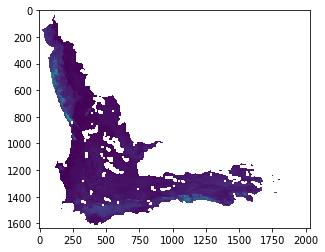

In [24]:
plt.imshow(soilN[0])

In [25]:
concentration = ro.open("https://github.com/AdamWilsonLab/emma_envdata/releases/download/processed_static/MODCF_seasonality_concentration.tif")
concentration = concentration.read()

In [26]:
np.unique(concentration)

array([0.5040532 , 0.5526344 , 0.80227834, ...,        nan,        nan,
              nan], dtype=float32)

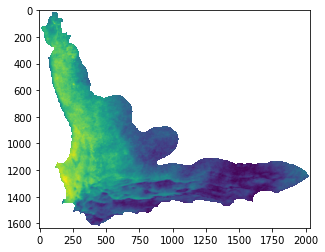

In [27]:
plt.imshow(concentration[0])

In [28]:
static_arr = np.empty((3,ndvi_dataset.shape[1],ndvi_dataset.shape[2]))
static_arr[0] = dem[0]
static_arr[1] = soilN[0]
static_arr[2] = concentration[0]


In [29]:
# define the normalization function
def MaxMinNormalization(x, norm_min, norm_max):
    """（0,1] normaliaztion"""
    x = (x - norm_min) / (norm_max - norm_min)
    return x

In [30]:
#normalize the environmental dataset
norm_covariates = np.zeros(static_arr.shape,dtype=np.float16)
for i in range(static_arr.shape[0]):
    norm_covariates[i] = MaxMinNormalization(static_arr[i],np.nanmin(static_arr[i])-1,np.nanmax(static_arr[i])+1)
print(norm_covariates.shape)

(3, 1634, 2035)


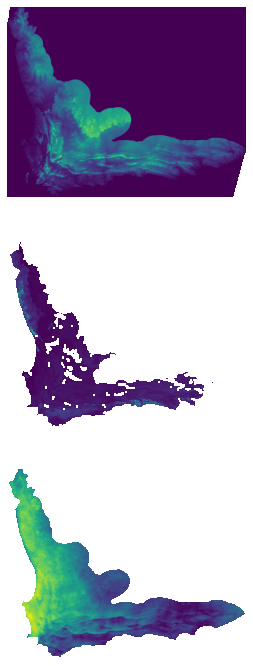

In [31]:
import random
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,4):
    plt.subplot(3,1,i)

    plt.imshow(norm_covariates[i-1,:,:])
    plt.axis('off')

In [32]:
np.nanmin(norm_covariates)

0.0004582

In [33]:
np.nanmax(norm_covariates)

0.9995

Collect dynamic data

In [34]:
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
prec_arr = np.empty((120,1634,2035))
current_time = 0
for y in range(2009,2019):
    for m in range(12):
        current_pr = ro.open("clipped_env/pr/pr_"+month[m]+"_"+str(y)+".tif")
        current_pr = current_pr.read(out_shape=(1,1634,2035),
        resampling=Resampling.bilinear)
        prec_arr[current_time] = current_pr[0]
        current_time = current_time + 1

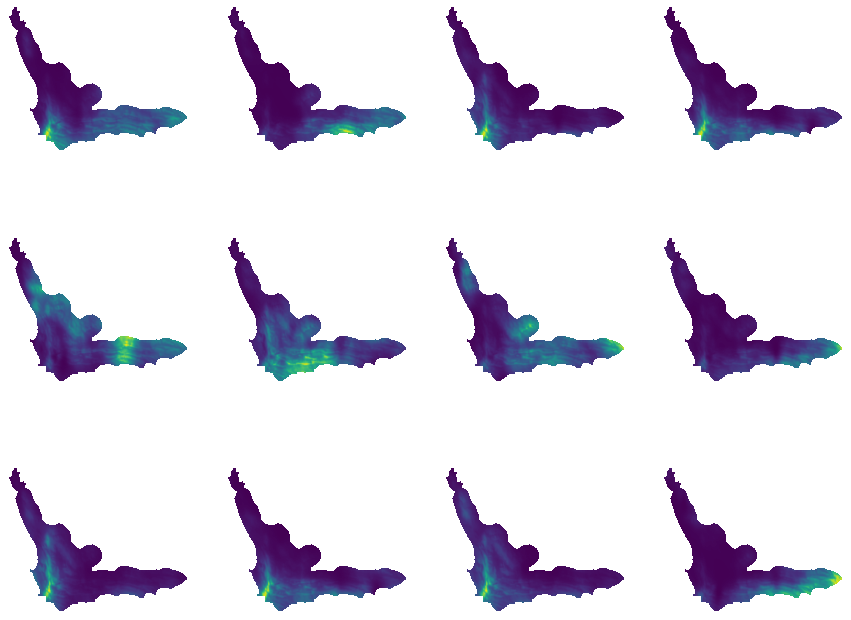

In [35]:

# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(prec_arr[random_time,:,:])
    plt.axis('off')

In [36]:
#normalize the environmental dataset
norm_pr = np.zeros(prec_arr.shape,dtype=np.float16)
for i in range(prec_arr.shape[0]):
    norm_pr[i] = MaxMinNormalization(prec_arr[i],np.nanmin(prec_arr[i])-1,np.nanmax(prec_arr[i])+1)
print(norm_pr.shape)

(120, 1634, 2035)


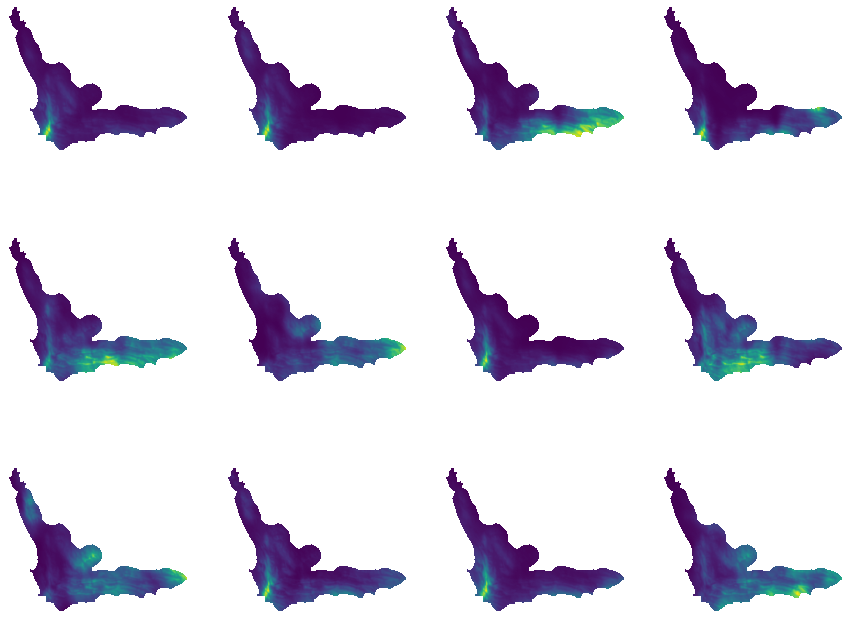

In [37]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(norm_pr[random_time,:,:])
    plt.axis('off')

In [38]:
np.nanmin(norm_pr)

1.6e-05

In [39]:
np.nanmax(norm_pr)

1.0

In [40]:
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
rsds_arr = np.empty((120,1634,2035))
current_time = 0
for y in range(2009,2019):
    for m in range(12):
        current_rsds = ro.open("clipped_env/rsds/rsds_"+month[m]+"_"+str(y)+".tif")
        current_rsds = current_rsds.read(out_shape=(1,1634,2035),
        resampling=Resampling.bilinear)
        rsds_arr[current_time] = current_rsds[0]
        current_time = current_time + 1

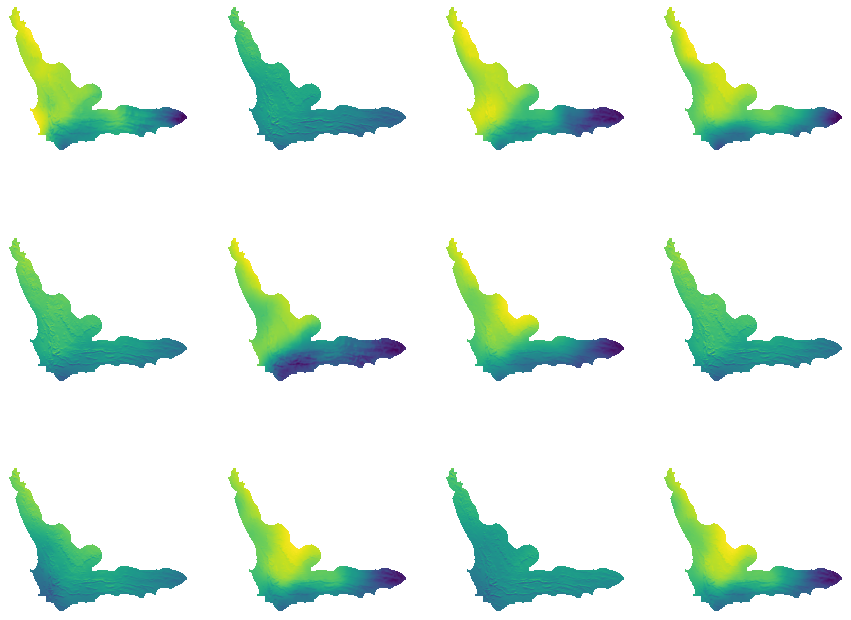

In [41]:

# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(rsds_arr[random_time,:,:])
    plt.axis('off')

In [42]:
#normalize the environmental dataset
norm_rsds = np.zeros(rsds_arr.shape,dtype=np.float16)
for i in range(rsds_arr.shape[0]):
    norm_rsds[i] = MaxMinNormalization(rsds_arr[i],np.nanmin(rsds_arr[i])-1,np.nanmax(rsds_arr[i])+1)
print(norm_rsds.shape)

(120, 1634, 2035)


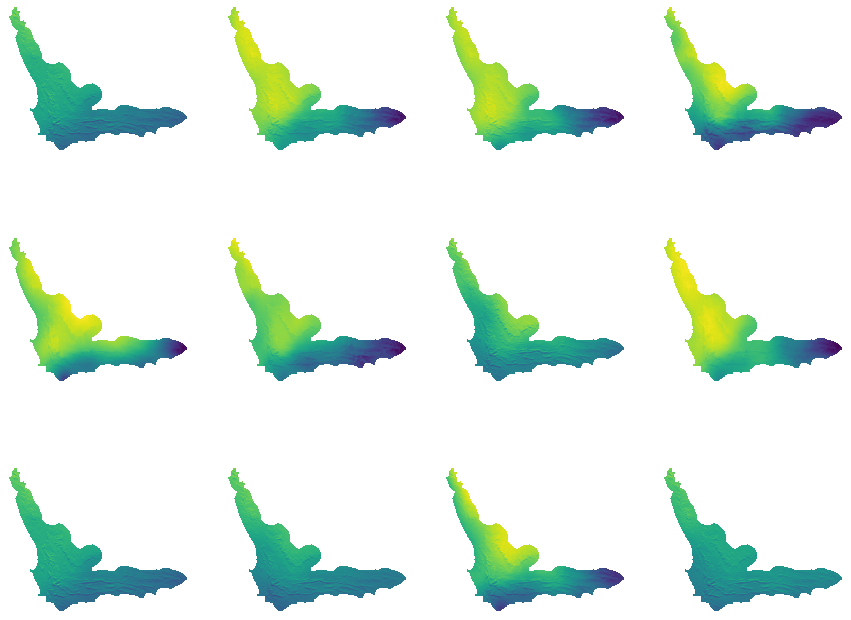

In [43]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(norm_rsds[random_time,:,:])
    plt.axis('off')

In [44]:
np.nanmin(norm_rsds)

0.05533

In [45]:
np.nanmax(norm_rsds)

0.945

In [46]:
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
tas_arr = np.empty((120,1634,2035))
current_time = 0
for y in range(2009,2019):
    for m in range(12):
        current_tas = ro.open("clipped_env/tas/tas_"+month[m]+"_"+str(y)+".tif")
        current_tas = current_tas.read(out_shape=(1,1634,2035),
        resampling=Resampling.bilinear)
        tas_arr[current_time] = current_tas[0]
        current_time = current_time + 1

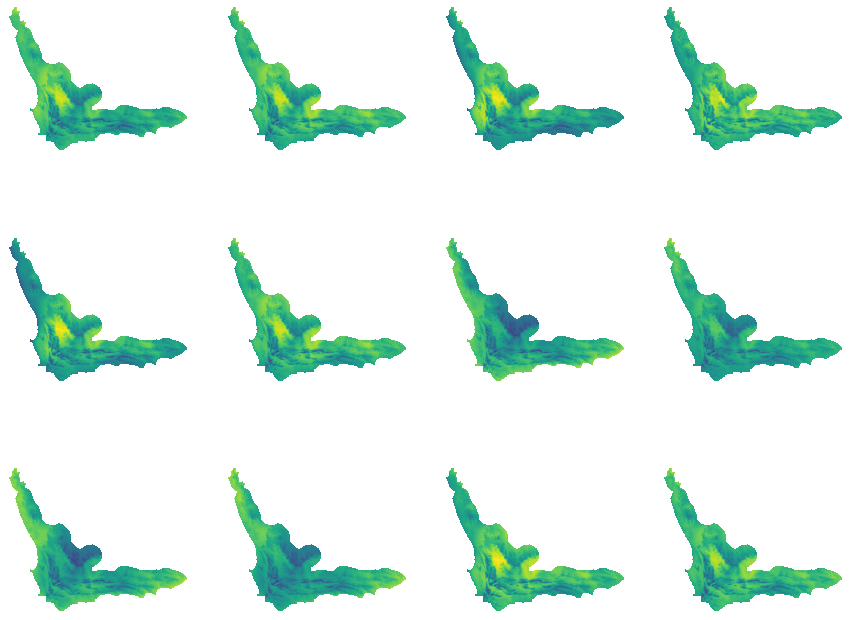

In [47]:
import random
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(tas_arr[random_time,:,:])
    plt.axis('off')

In [48]:
#normalize the environmental dataset
norm_tas = np.zeros(tas_arr.shape,dtype=np.float16)
for i in range(tas_arr.shape[0]):
    norm_tas[i] = MaxMinNormalization(tas_arr[i],np.nanmin(tas_arr[i])-1,np.nanmax(tas_arr[i])+1)
print(norm_tas.shape)

(120, 1634, 2035)


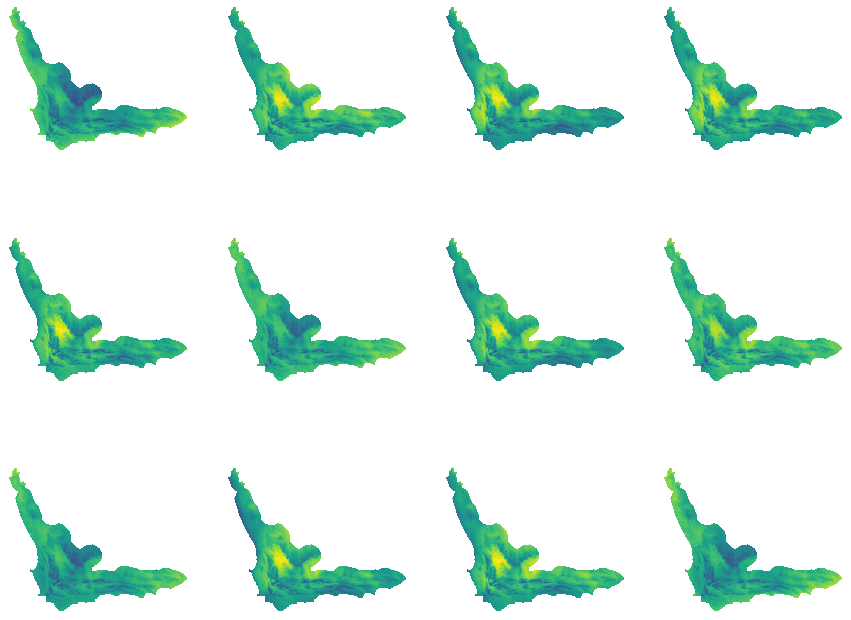

In [49]:
# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    random_time = random.randint(0,119)
    plt.imshow(norm_tas[random_time,:,:])
    plt.axis('off')

In [50]:
np.nanmin(norm_tas)

0.00373

In [51]:
np.nanmax(norm_tas)

0.996

In [52]:
all_variables = np.empty((120,1634,2035,7))

for i in range(120):
    for m in range(1634):
        for n in range(2035):
            all_variables[i,m,n,0] = ndvi_arr[i,m,n]
            all_variables[i,m,n,1] = norm_covariates[0,m,n]
            all_variables[i,m,n,2] = norm_covariates[1,m,n]
            all_variables[i,m,n,3] = norm_covariates[2,m,n]
            all_variables[i,m,n,4] = norm_pr[i,m,n]
            all_variables[i,m,n,5] = norm_rsds[i,m,n]
            all_variables[i,m,n,6] = norm_tas[i,m,n]

In [53]:
all_variables_mask = np.empty((1634,2035))
for i in range(1634):
    for j in range(2035):
        found_nan = False

        if np.isnan(all_variables[:,i,j,:]).any():
            found_nan = True



        if found_nan:
            all_variables_mask[i,j] = -1
        else:
            all_variables_mask[i,j] = 1

In [54]:
"""
all_variables_mask = np.empty((1634,2035))
for i in range(1634):
    for j in range(2035):
        found_nan = False
        for t1 in range(120):
            if np.isnan(all_variables[t1,i,j,0]):
                found_nan = True
                break
        for t2 in range(120):
            if np.isnan(all_variables[t2,i,j,1]):
                found_nan = True
                break
        for t3 in range(120):
            if np.isnan(all_variables[t3,i,j,2]):
                found_nan = True
                break
        for t4 in range(120):
            if np.isnan(all_variables[t4,i,j,3]):
                found_nan = True
                break
        for t5 in range(120):
            if np.isnan(all_variables[t5,i,j,4]):
                found_nan = True
                break
        for t6 in range(120):
            if np.isnan(all_variables[t6,i,j,5]):
                found_nan = True
                break
        for t7 in range(120):
            if np.isnan(all_variables[t7,i,j,6]):
                found_nan = True
                break




        if found_nan:
            all_variables_mask[i,j] = -1
        else:
            all_variables_mask[i,j] = 1
"""

'\nall_variables_mask = np.empty((1634,2035))\nfor i in range(1634):\n    for j in range(2035):\n        found_nan = False\n        for t1 in range(120):\n            if np.isnan(all_variables[t1,i,j,0]):\n                found_nan = True\n                break\n        for t2 in range(120):\n            if np.isnan(all_variables[t2,i,j,1]):\n                found_nan = True\n                break\n        for t3 in range(120):\n            if np.isnan(all_variables[t3,i,j,2]):\n                found_nan = True\n                break\n        for t4 in range(120):\n            if np.isnan(all_variables[t4,i,j,3]):\n                found_nan = True\n                break\n        for t5 in range(120):\n            if np.isnan(all_variables[t5,i,j,4]):\n                found_nan = True\n                break\n        for t6 in range(120):\n            if np.isnan(all_variables[t6,i,j,5]):\n                found_nan = True\n                break\n        for t7 in range(120):\n           

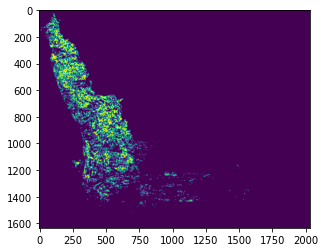

In [55]:
plt.imshow(all_variables_mask)

collect classification data

In [56]:
class_arr = np.empty((10,1634,2035))

year = ["09","10","11","12","13","14","15","16","17","18"]

current_time = 0
for y in range(10):

    current_class = ro.open("africa_classification_CFR/"+year[y]+"_CFR.tif")
    current_class = current_class.read()
    class_arr[current_time] = current_class[0]
    current_time = current_time + 1

In [57]:
np.shape(class_arr)

(10, 1634, 2035)

In [58]:
np.unique(class_arr)

array([  0.,  20.,  30.,  41.,  42.,  43.,  50.,  60.,  80.,  90., 112.,
       114., 116., 124., 126.])

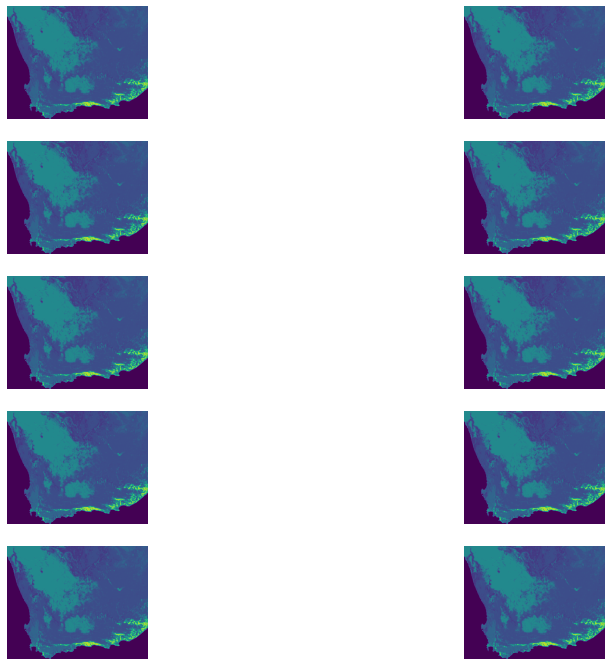

In [59]:

# visualize random 12 NDVI values of SMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,11):
    plt.subplot(5,2,i)

    plt.imshow(class_arr[i-1,:,:])
    plt.axis('off')

In [60]:
class_mask = np.empty((class_arr.shape[1],class_arr.shape[2]))
for m in range(class_mask.shape[0]):
    for n in range(class_mask.shape[1]):
        found_change = False
        for t in range(1,10):
            if (class_arr[0,m,n] != class_arr[t,m,n]) or (class_arr[0,m,n] == 0):
                found_change = True
                break

        
        
        if found_change:
            class_mask[m,n] = -1
        else:
            class_mask[m,n] = 1

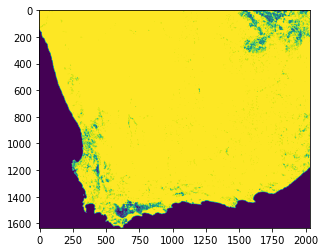

In [61]:
plt.imshow(class_mask)

In [62]:
combine_mask = np.empty(all_variables_mask.shape)

for m in range(all_variables_mask.shape[0]):
    for n in range(all_variables_mask.shape[1]):
        if all_variables_mask[m,n] == 1 and class_mask[m,n] == 1:
            combine_mask[m,n] = 1
        else:
            combine_mask[m,n] = -1

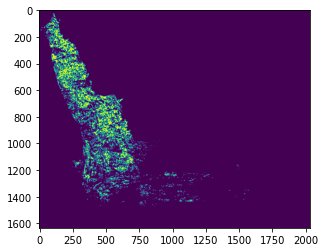

In [63]:
plt.imshow(combine_mask)

build dataset

In [64]:
valid_number = 0
for i in range(combine_mask.shape[0]):
    for j in range(combine_mask.shape[1]):
        if combine_mask[i,j] == 1:
            valid_number += 1
        else:
            pass
print(valid_number)

145268


In [65]:
train_number = int(valid_number*0.75)
test_number = int(valid_number*0.25)

In [66]:
# replace the original label with continous label
# original label array([  0.,  20.,  30.,  41.,  42.,  43.,  50.,  60.,  80.,  90., 112.,114., 116., 124., 126.])
# have already excluded the 0s
lab_dict = {'20.0':'0',
            '30.0':'1',
            '41.0':'2',
            '42.0':'3',
            '43.0':'4',
            '50.0':'5',
            '60.0':'6',
            '80.0':'7',
            '90.0':'8',
            '112.0':'9',
            '114.0':'10',
            '116.0':'11',
            '124.0':'12',
            '126.0':'13'}

In [67]:
total_dataset = np.empty((valid_number,120,7))
total_label = np.empty((valid_number,1))
total_dataset_count = 0
for i in range(combine_mask.shape[0]):
    for j in range(combine_mask.shape[1]):
        if combine_mask[i,j] == 1:
            total_dataset[total_dataset_count,:,:] = all_variables[:,i,j,:]
            trans_lab = lab_dict[str(class_arr[0,i,j])]
            total_label[total_dataset_count,0] = int(trans_lab)
    
            total_dataset_count = total_dataset_count+1

In [68]:
print(total_dataset_count)

145268


In [69]:
random_int = random.sample(range(valid_number),train_number)
random.seed(10000)
train_dataset = []
train_label = []
test_dataset = []
test_label = []
for i in range(valid_number):
    if i in random_int:
        train_dataset.append(total_dataset[i])
        train_label.append(total_label[i])
    else:
        test_dataset.append(total_dataset[i])
        test_label.append(total_label[i])

In [70]:
np.shape(train_dataset)

(108951, 120, 7)

In [71]:
np.unique(train_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

In [72]:
np.shape(test_dataset)

(36317, 120, 7)

In [73]:
np.unique(test_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

In [74]:
np.unique(train_dataset)

array([-0.18994141, -0.17004395, -0.16003418, ...,  0.99902344,
        0.99951172,  1.        ])

In [75]:
train_dataset = np.asarray(train_dataset)
train_label = np.asarray(train_label)

In [76]:
test_dataset = np.asarray(test_dataset)
test_label = np.asarray(test_label)

In [77]:
train_label.shape

(108951, 1)

In [78]:
train_dataset = train_dataset.reshape(train_dataset.shape + (1,))
train_label = keras.utils.to_categorical(train_label,14)

In [79]:
test_dataset = test_dataset.reshape(test_dataset.shape + (1,))
test_label = keras.utils.to_categorical(test_label,14)

In [80]:
train_dataset.shape

(108951, 120, 7, 1)

In [81]:
train_label.shape

(108951, 14)

In [82]:
train_dataset.shape[1:]

(120, 7, 1)

In [83]:
def build_FCN():
    tf.random.set_seed(42)

    FCN_model = keras.Sequential(
        [
            layers.Input(train_dataset.shape[1:]),
            
            layers.Conv2D(128, 5, 1, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            
            layers.Conv2D(256, 5, 1, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.Conv2D(128, 3, 1, padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.GlobalAveragePooling2D(),
            layers.Dense(14, activation='softmax')

        ]
    )
    FCN_model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

    return FCN_model

In [84]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor=0.5, patience=50, min_lr=0.0001) 
#Train the model
FCN_model = build_FCN()

epochs = 500

history = FCN_model.fit(
    train_dataset,
    train_label,
    batch_size=7000,
    epochs=epochs,
    verbose=1,
    validation_data=(test_dataset, test_label),
    callbacks=[reduce_lr]
)

FCN_model.save('FCN_reduce_lr_500epochs.h5')

2022-10-27 02:00:02.940466: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-27 02:00:02.980724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-10-27 02:00:02.981757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-27 02:00:02.996343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-27 02:00:03.008767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-27 02:00:03.010924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-

Epoch 1/500
Epoch 1/500
16/16 [==============================] - 2194s 137s/step - loss: 1.5814 - accuracy: 0.5377 - val_loss: 2.3159 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 2/500
16/16 [==============================] - 2196s 137s/step - loss: 0.9969 - accuracy: 0.6706 - val_loss: 2.0395 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 3/500
16/16 [==============================] - 2148s 134s/step - loss: 0.8819 - accuracy: 0.6813 - val_loss: 2.0195 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 4/500
16/16 [==============================] - 2172s 136s/step - loss: 0.8384 - accuracy: 0.6882 - val_loss: 2.0681 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 5/500
16/16 [==============================] - 2215s 138s/step - loss: 0.8146 - accuracy: 0.6910 - val_loss: 2.1282 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 6/500
16/16 [==============================] - 2187s 137s/step - 

KeyboardInterrupt: 